In [48]:
import pandas as pd
import numpy as np
import sklearn.datasets
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
%matplotlib notebook

In [3]:
cancer =  sklearn.datasets.load_breast_cancer()
cancer_df =  pd.DataFrame(cancer.data, columns =  cancer.feature_names)
cancer_df ['Target'] =  cancer.target
X = cancer_df.iloc[:,0:-1]
y =  cancer_df['Target']

# Apply K nearest neighbor and  SVM on the cancer dataset and compare the perforamnce by ROC, AUC, accuracy and confusion matrix

## Using Random Forest for feature selection

In [4]:
scaler =  MinMaxScaler((0,1))
X_scaled =  scaler.fit_transform(X)
X_scaled_df =  pd.DataFrame(X_scaled, columns =  X.columns)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled_df,y, train_size =  0.8, random_state = 1 )
#print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

In [6]:
rf_classifier =  RandomForestClassifier()

In [7]:
rf_classifier.fit(X_train,y_train)
rf_classifier.feature_importances_

array([0.02454395, 0.02275538, 0.04037662, 0.05548124, 0.00637025,
       0.00898493, 0.06231973, 0.09838917, 0.00471332, 0.00392681,
       0.0141284 , 0.00401023, 0.00730254, 0.05216248, 0.00394781,
       0.00341844, 0.00316923, 0.00245842, 0.00338861, 0.00297618,
       0.13689123, 0.02046104, 0.14885748, 0.06826281, 0.00798775,
       0.02017652, 0.04851402, 0.11115935, 0.00719757, 0.00566847])

In [8]:
imp =  pd.DataFrame([rf_classifier.feature_importances_],columns =  X.columns).T.rename({0:'Imp'},axis = 1).sort_values(by = ['Imp'],ascending = False)

In [9]:
features_to_remove = imp[imp['Imp'] <= 0.05].index

In [10]:
X_train.drop(features_to_remove, axis = 1, inplace = True)
X_test.drop(features_to_remove, axis = 1, inplace = True)

## Setting a baseline acuracy

In [11]:
dummy = DummyClassifier(strategy =  'constant', random_state = 1, constant = 1)
dummy.fit(X_train,y_train)
dummy.score(X_test,y_test)

0.631578947368421

## K near neighbor Claasifer

In [12]:
knn =  KNeighborsClassifier()


parameter_grid = {"n_neighbors" : np.arange(5,21,2) , "weights"  : ["uniform", "distance"]}
grid_search =  GridSearchCV(estimator = knn, param_grid = parameter_grid, cv=  5, verbose = 4, scoring  = ['recall','accuracy'], refit = False )

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END n_neighbors=5, weights=uniform; accuracy: (test=0.912) recall: (test=0.877) total time=   0.0s
[CV 2/5] END n_neighbors=5, weights=uniform; accuracy: (test=0.934) recall: (test=0.912) total time=   0.0s
[CV 3/5] END n_neighbors=5, weights=uniform; accuracy: (test=0.945) recall: (test=0.947) total time=   0.0s
[CV 4/5] END n_neighbors=5, weights=uniform; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 5/5] END n_neighbors=5, weights=uniform; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 1/5] END n_neighbors=5, weights=distance; accuracy: (test=0.912) recall: (test=0.877) total time=   0.0s
[CV 2/5] END n_neighbors=5, weights=distance; accuracy: (test=0.923) recall: (test=0.912) total time=   0.0s
[CV 3/5] END n_neighbors=5, weights=distance; accuracy: (test=0.945) recall: (test=0.947) total time=   0.0s
[CV 4/5] END n_neighbors=5, weights=distance; accuracy: (test=0.923) rec

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 5,  7,  9, 11, 13, 15, 17, 19]),
                         'weights': ['uniform', 'distance']},
             refit=False, scoring=['recall', 'accuracy'], verbose=4)

In [13]:
knn_gds_cv_result =  pd.DataFrame(grid_search.cv_results_) 
knn_gds_cv_result.sort_values(by = 'mean_test_accuracy').to_csv('result.csv')

In [14]:
knn1  = KNeighborsClassifier(n_neighbors = 11, weights =  'distance')
knn1.fit(X_train,y_train)
knn_case_1 = knn1.predict(X_test)


knn2  = KNeighborsClassifier(n_neighbors = 5, weights =  'uniform')
knn2.fit(X_train,y_train)
knn_case_2 = knn2.predict(X_test)



In [15]:
confusion_matrix(y_test,knn_case_1)

array([[37,  5],
       [ 1, 71]])

In [16]:
knn1_proba = knn1.predict_proba(X_test)
knn2_proba = knn2.predict_proba(X_test)

In [17]:
fpr1,tpr1,threshold1 = roc_curve(y_test,knn1_proba[:,1])
auc1 = roc_auc_score(y_test,knn1_proba[:,1])
fpr2,tpr2,threshold2 = roc_curve(y_test,knn2_proba[:,1])
auc2 = roc_auc_score(y_test,knn2_proba[:,1])

<IPython.core.display.Javascript object>


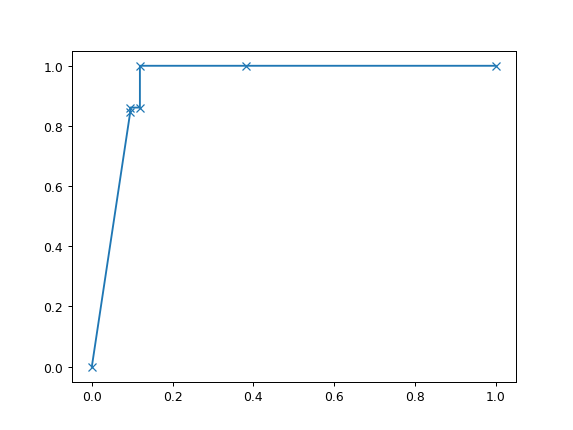

In [37]:
plt.figure()
plt.plot(fpr1,tpr1, marker = 'x')
#plt.plot(fpr2,tpr2,marker = 'o')

In [19]:
print(auc1,auc2)

0.9417989417989417 0.945271164021164


In [20]:
threshold1

array([       inf, 1.        , 0.9376715 , 0.89594032, 0.36674616,
       0.06382502, 0.        ])

In [21]:
knn1_proba_df =  pd.DataFrame(knn1_proba)
knn1_proba_df['Target'] =  y_test.values

In [22]:
knn1_proba_df.sort_values(by = 0)

,0,1,Target
2,0.000000,1.000000,1
15,0.000000,1.000000,1
10,0.000000,1.000000,1
8,0.000000,1.000000,1
13,0.000000,1.000000,1
21,0.000000,1.000000,1
17,0.000000,1.000000,1
16,0.000000,1.000000,1
20,0.000000,1.000000,1
31,0.000000,1.000000,1


In [44]:
pr,rc,th =  precision_recall_curve(y_test,knn1_proba[:,1])
th

array([0.        , 0.06382502, 0.09339623, 0.09625398, 0.14853285,
       0.14900526, 0.18693332, 0.18980145, 0.23499606, 0.27281421,
       0.28032693, 0.32511001, 0.36674616, 0.50137252, 0.61294246,
       0.66511834, 0.82855421, 0.83005997, 0.83806537, 0.85010266,
       0.85170614, 0.86113147, 0.89594032, 0.9376715 , 1.        ])

<IPython.core.display.Javascript object>


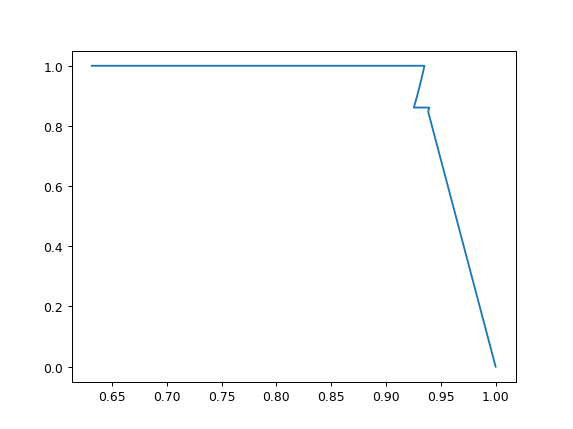

In [45]:
plt.figure()
plt.plot(pr,rc)


## Based on the above, we can say that the best KNN classifier is with n = 11, weights =  distance and the probality threshold at 0.6.

## Setting up a classifier for SVC and then compare the two classifer

In [25]:
svc = SVC(kernel =  'rbf')

svc_parameter_grid =  {'C' : np.arange(8,11,0.1), 'gamma' : np.arange(2,3,0.1)}
svc_grid_search =  GridSearchCV(estimator =  svc, param_grid = svc_parameter_grid , scoring= ['recall','accuracy'], cv =  5, verbose = 4, refit = False )

svc_grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5] END C=8.0, gamma=2.0; accuracy: (test=0.890) recall: (test=0.860) total time=   0.0s
[CV 2/5] END C=8.0, gamma=2.0; accuracy: (test=0.923) recall: (test=0.947) total time=   0.0s
[CV 3/5] END C=8.0, gamma=2.0; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8.0, gamma=2.0; accuracy: (test=0.934) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=8.0, gamma=2.0; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.0, gamma=2.1; accuracy: (test=0.890) recall: (test=0.860) total time=   0.0s
[CV 2/5] END C=8.0, gamma=2.1; accuracy: (test=0.923) recall: (test=0.947) total time=   0.0s
[CV 3/5] END C=8.0, gamma=2.1; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8.0, gamma=2.1; accuracy: (test=0.934) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=8.0, gamma=2.1; accuracy: (test=0.956) recall: (test=1.000) total time=   0

[CV 5/5] END C=8.1, gamma=2.5000000000000004; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.1, gamma=2.6000000000000005; accuracy: (test=0.901) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=8.1, gamma=2.6000000000000005; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8.1, gamma=2.6000000000000005; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8.1, gamma=2.6000000000000005; accuracy: (test=0.934) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=8.1, gamma=2.6000000000000005; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.1, gamma=2.7000000000000006; accuracy: (test=0.901) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=8.1, gamma=2.7000000000000006; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8.1, gamma=2.7000000000000006; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8.1,

[CV 5/5] END C=8.299999999999999, gamma=2.3000000000000003; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.299999999999999, gamma=2.4000000000000004; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=8.299999999999999, gamma=2.4000000000000004; accuracy: (test=0.934) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8.299999999999999, gamma=2.4000000000000004; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8.299999999999999, gamma=2.4000000000000004; accuracy: (test=0.945) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=8.299999999999999, gamma=2.4000000000000004; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.299999999999999, gamma=2.5000000000000004; accuracy: (test=0.901) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=8.299999999999999, gamma=2.5000000000000004; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8

[CV 3/5] END C=8.399999999999999, gamma=2.8000000000000007; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8.399999999999999, gamma=2.8000000000000007; accuracy: (test=0.945) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=8.399999999999999, gamma=2.8000000000000007; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.399999999999999, gamma=2.900000000000001; accuracy: (test=0.934) recall: (test=0.930) total time=   0.0s
[CV 2/5] END C=8.399999999999999, gamma=2.900000000000001; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8.399999999999999, gamma=2.900000000000001; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8.399999999999999, gamma=2.900000000000001; accuracy: (test=0.945) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=8.399999999999999, gamma=2.900000000000001; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.4999

[CV 1/5] END C=8.599999999999998, gamma=2.3000000000000003; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=8.599999999999998, gamma=2.3000000000000003; accuracy: (test=0.934) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8.599999999999998, gamma=2.3000000000000003; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8.599999999999998, gamma=2.3000000000000003; accuracy: (test=0.945) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=8.599999999999998, gamma=2.3000000000000003; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.599999999999998, gamma=2.4000000000000004; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=8.599999999999998, gamma=2.4000000000000004; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8.599999999999998, gamma=2.4000000000000004; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8

[CV 5/5] END C=8.699999999999998, gamma=2.7000000000000006; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.699999999999998, gamma=2.8000000000000007; accuracy: (test=0.934) recall: (test=0.930) total time=   0.0s
[CV 2/5] END C=8.699999999999998, gamma=2.8000000000000007; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8.699999999999998, gamma=2.8000000000000007; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8.699999999999998, gamma=2.8000000000000007; accuracy: (test=0.945) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=8.699999999999998, gamma=2.8000000000000007; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.699999999999998, gamma=2.900000000000001; accuracy: (test=0.901) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=8.699999999999998, gamma=2.900000000000001; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8.6

[CV 1/5] END C=8.899999999999997, gamma=2.5000000000000004; accuracy: (test=0.901) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=8.899999999999997, gamma=2.5000000000000004; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8.899999999999997, gamma=2.5000000000000004; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8.899999999999997, gamma=2.5000000000000004; accuracy: (test=0.934) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=8.899999999999997, gamma=2.5000000000000004; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.899999999999997, gamma=2.6000000000000005; accuracy: (test=0.912) recall: (test=0.895) total time=   0.0s
[CV 2/5] END C=8.899999999999997, gamma=2.6000000000000005; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=8.899999999999997, gamma=2.6000000000000005; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=8

[CV 5/5] END C=8.999999999999996, gamma=2.900000000000001; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.099999999999996, gamma=2.0; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=9.099999999999996, gamma=2.0; accuracy: (test=0.934) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.099999999999996, gamma=2.0; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=9.099999999999996, gamma=2.0; accuracy: (test=0.945) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=9.099999999999996, gamma=2.0; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.099999999999996, gamma=2.1; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=9.099999999999996, gamma=2.1; accuracy: (test=0.934) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.099999999999996, gamma=2.1; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C

[CV 2/5] END C=9.199999999999996, gamma=2.6000000000000005; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.199999999999996, gamma=2.6000000000000005; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=9.199999999999996, gamma=2.6000000000000005; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=9.199999999999996, gamma=2.6000000000000005; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.199999999999996, gamma=2.7000000000000006; accuracy: (test=0.923) recall: (test=0.912) total time=   0.0s
[CV 2/5] END C=9.199999999999996, gamma=2.7000000000000006; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.199999999999996, gamma=2.7000000000000006; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=9.199999999999996, gamma=2.7000000000000006; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=9

[CV 1/5] END C=9.399999999999995, gamma=2.1; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=9.399999999999995, gamma=2.1; accuracy: (test=0.934) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.399999999999995, gamma=2.1; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=9.399999999999995, gamma=2.1; accuracy: (test=0.945) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=9.399999999999995, gamma=2.1; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.399999999999995, gamma=2.2; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=9.399999999999995, gamma=2.2; accuracy: (test=0.934) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.399999999999995, gamma=2.2; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=9.399999999999995, gamma=2.2; accuracy: (test=0.945) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=9.39999999999

[CV 2/5] END C=9.499999999999995, gamma=2.8000000000000007; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.499999999999995, gamma=2.8000000000000007; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=9.499999999999995, gamma=2.8000000000000007; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=9.499999999999995, gamma=2.8000000000000007; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.499999999999995, gamma=2.900000000000001; accuracy: (test=0.890) recall: (test=0.860) total time=   0.0s
[CV 2/5] END C=9.499999999999995, gamma=2.900000000000001; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.499999999999995, gamma=2.900000000000001; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=9.499999999999995, gamma=2.900000000000001; accuracy: (test=0.945) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=9.499

[CV 4/5] END C=9.699999999999994, gamma=2.3000000000000003; accuracy: (test=0.934) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=9.699999999999994, gamma=2.3000000000000003; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.699999999999994, gamma=2.4000000000000004; accuracy: (test=0.901) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=9.699999999999994, gamma=2.4000000000000004; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.699999999999994, gamma=2.4000000000000004; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=9.699999999999994, gamma=2.4000000000000004; accuracy: (test=0.945) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=9.699999999999994, gamma=2.4000000000000004; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.699999999999994, gamma=2.5000000000000004; accuracy: (test=0.912) recall: (test=0.895) total time=   0.0s
[CV 2/5] END C=9

[CV 4/5] END C=9.799999999999994, gamma=2.7000000000000006; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=9.799999999999994, gamma=2.7000000000000006; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.799999999999994, gamma=2.8000000000000007; accuracy: (test=0.890) recall: (test=0.860) total time=   0.0s
[CV 2/5] END C=9.799999999999994, gamma=2.8000000000000007; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.799999999999994, gamma=2.8000000000000007; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=9.799999999999994, gamma=2.8000000000000007; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=9.799999999999994, gamma=2.8000000000000007; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.799999999999994, gamma=2.900000000000001; accuracy: (test=0.890) recall: (test=0.860) total time=   0.0s
[CV 2/5] END C=9.

[CV 4/5] END C=9.999999999999993, gamma=2.2; accuracy: (test=0.934) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=9.999999999999993, gamma=2.2; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.999999999999993, gamma=2.3000000000000003; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=9.999999999999993, gamma=2.3000000000000003; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=9.999999999999993, gamma=2.3000000000000003; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=9.999999999999993, gamma=2.3000000000000003; accuracy: (test=0.934) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=9.999999999999993, gamma=2.3000000000000003; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=9.999999999999993, gamma=2.4000000000000004; accuracy: (test=0.901) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=9.999999999999993, gamma=2.4000

[CV 3/5] END C=10.099999999999993, gamma=2.7000000000000006; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=10.099999999999993, gamma=2.7000000000000006; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=10.099999999999993, gamma=2.7000000000000006; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.099999999999993, gamma=2.8000000000000007; accuracy: (test=0.890) recall: (test=0.860) total time=   0.0s
[CV 2/5] END C=10.099999999999993, gamma=2.8000000000000007; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=10.099999999999993, gamma=2.8000000000000007; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=10.099999999999993, gamma=2.8000000000000007; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=10.099999999999993, gamma=2.8000000000000007; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5]

[CV 3/5] END C=10.299999999999992, gamma=2.1; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=10.299999999999992, gamma=2.1; accuracy: (test=0.945) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=10.299999999999992, gamma=2.1; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.299999999999992, gamma=2.2; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=10.299999999999992, gamma=2.2; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=10.299999999999992, gamma=2.2; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=10.299999999999992, gamma=2.2; accuracy: (test=0.934) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=10.299999999999992, gamma=2.2; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.299999999999992, gamma=2.3000000000000003; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 

[CV 4/5] END C=10.399999999999991, gamma=2.5000000000000004; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=10.399999999999991, gamma=2.5000000000000004; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.399999999999991, gamma=2.6000000000000005; accuracy: (test=0.901) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=10.399999999999991, gamma=2.6000000000000005; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=10.399999999999991, gamma=2.6000000000000005; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=10.399999999999991, gamma=2.6000000000000005; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=10.399999999999991, gamma=2.6000000000000005; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.399999999999991, gamma=2.7000000000000006; accuracy: (test=0.890) recall: (test=0.860) total time=   0.0s
[CV 2/5]

[CV 4/5] END C=10.59999999999999, gamma=2.1; accuracy: (test=0.945) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=10.59999999999999, gamma=2.1; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.59999999999999, gamma=2.2; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=10.59999999999999, gamma=2.2; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=10.59999999999999, gamma=2.2; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=10.59999999999999, gamma=2.2; accuracy: (test=0.945) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=10.59999999999999, gamma=2.2; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.59999999999999, gamma=2.3000000000000003; accuracy: (test=0.890) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=10.59999999999999, gamma=2.3000000000000003; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0

[CV 4/5] END C=10.69999999999999, gamma=2.5000000000000004; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=10.69999999999999, gamma=2.5000000000000004; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.69999999999999, gamma=2.6000000000000005; accuracy: (test=0.890) recall: (test=0.860) total time=   0.0s
[CV 2/5] END C=10.69999999999999, gamma=2.6000000000000005; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=10.69999999999999, gamma=2.6000000000000005; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=10.69999999999999, gamma=2.6000000000000005; accuracy: (test=0.956) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=10.69999999999999, gamma=2.6000000000000005; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.69999999999999, gamma=2.7000000000000006; accuracy: (test=0.890) recall: (test=0.860) total time=   0.0s
[CV 2/5] END C=1

[CV 3/5] END C=10.89999999999999, gamma=2.2; accuracy: (test=0.978) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=10.89999999999999, gamma=2.2; accuracy: (test=0.945) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=10.89999999999999, gamma=2.2; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.89999999999999, gamma=2.3000000000000003; accuracy: (test=0.901) recall: (test=0.877) total time=   0.0s
[CV 2/5] END C=10.89999999999999, gamma=2.3000000000000003; accuracy: (test=0.923) recall: (test=0.965) total time=   0.0s
[CV 3/5] END C=10.89999999999999, gamma=2.3000000000000003; accuracy: (test=0.967) recall: (test=0.982) total time=   0.0s
[CV 4/5] END C=10.89999999999999, gamma=2.3000000000000003; accuracy: (test=0.945) recall: (test=0.982) total time=   0.0s
[CV 5/5] END C=10.89999999999999, gamma=2.3000000000000003; accuracy: (test=0.956) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=10.89999999999999, gamma=2.4000000000000004; a

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([ 8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,
        9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1,
       10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9]),
                         'gamma': array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9])},
             refit=False, scoring=['recall', 'accuracy'], verbose=4)

In [26]:
svc_grid_search_result =  pd.DataFrame(svc_grid_search.cv_results_)
svc_grid_search_result['Avg'] =  (svc_grid_search_result['mean_test_recall'] + svc_grid_search_result['mean_test_accuracy'])/2
svc_grid_search_result.sort_values(by =  'Avg').to_csv('svc_results.csv')


In [27]:
svc1  = SVC(probability = True, kernel =  'rbf', C= 11, gamma =  3, random_state = 1)
svc1.fit(X_train,y_train)
svc_case1 = svc1.predict(X_test)

In [28]:
confusion_matrix(y_test,svc_case1)

array([[37,  5],
       [ 1, 71]])

In [35]:
svc1_predict_prob = pd.DataFrame(svc1.predict_proba(X_test) )
svc1_predict_prob['Target'] = y_test.values
svc1_predict_prob.sort_values(by = 0)


,0,1,Target
2,0.005557,0.994443,1
71,0.005636,0.994364,1
84,0.005671,0.994329,1
56,0.005852,0.994148,1
31,0.005933,0.994067,1
58,0.006129,0.993871,1
13,0.006224,0.993776,1
43,0.006396,0.993604,1
59,0.006616,0.993384,1
92,0.007099,0.992901,1


In [30]:
svc_fpr,svc_tpr,svc_threshold = roc_curve(y_test,svc1_predict_prob[1])

In [34]:
svc_threshold

array([           inf, 9.94442714e-01, 9.86302448e-01, 9.86039405e-01,
       9.71067480e-01, 9.69520662e-01, 9.20932758e-01, 9.11798983e-01,
       8.87239995e-01, 8.83248477e-01, 8.11255706e-01, 7.91774266e-01,
       4.17016168e-01, 1.85701513e-04])

<IPython.core.display.Javascript object>


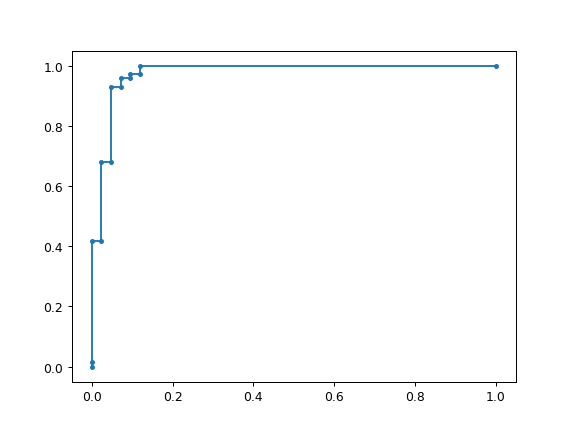

In [36]:
plt.figure()
plt.plot(svc_fpr,svc_tpr, marker = '.')
#plt.plot(fpr1,tpr1, marker = 'x')
#plt.plot(fpr2,tpr2,marker = 'o')

In [51]:
svc_auc = roc_auc_score(y_test,svc1_predict_prob[1])
knn_auc = roc_auc_score(y_test,knn1_proba[:,1])

## SVC Classifer with rbf kernel with C = 11 , gamma = 3 and probablity threshold of 0.5 can be selected. Out of the KNN and SVC, SVC is better as per the auc scores.

### We have  choosen lower values for probality threshold so that we capture all + ive cases at the cost of few - ive being classfeid as +ive.